In [1]:
### Imports ###
from nntomo.network import nnfbp_training, get_MSE_evolution, msdnet_training
from nntomo.nnfbp import DatasetNNFBP
from nntomo.msdnet import DatasetMSDNET
from nntomo.projection_stack import ProjectionStack
from nntomo.utilities import get_MSE_loss
import matplotlib.pyplot as plt
import numpy as np
import os

%load_ext autoreload
%autoreload 2

### Training data

For the training dataset, simulated STEM projections fo different MOF structures are taken for the inputs and the SIRT reconstruction with 72 projections is used for the real output values. The selected MOF structures are: MOF-5, PCN-61, IRMOF-76, ZIF-4 and MOF-1131.

In [2]:
training_mofs = ['MOF-5', 'PCN-61', 'IRMOF-76', 'ZIF-4', 'MOF-1131']
cell_repetitions = [3, 2, 2, 5, 3] # Chosen so that the number of voxels around the first axis is roughly the same

training_stacks = []

Nth = 144


for mof, cell_repetition in zip(training_mofs, cell_repetitions):
    cif_file = f"data/cif_files/{mof}.cif"
    proj_file = f"data/projection_files/{mof}-{cell_repetition}{cell_repetition}1-haadf{Nth}proj-resized512.mrc"
    if not os.path.isfile(proj_file):
        projections = ProjectionStack.from_cif_file(cif_file, Nth, 'full',
                                                    mode = 'haadf',
                                                    cell_repetition= (cell_repetition,cell_repetition,1),
                                                    gaussian_filter=.3,
                                                    #dose_per_area_noise=100,
                                                    #nb_frozen_phonons = 4,
                                                    )
        projections = projections.get_resized_proj(512)
        projections.save()
    else:
        projections = ProjectionStack.from_mrc_file(proj_file, 'full')
    training_stacks.append(projections)


data/projection_files/MOF-5-331-haadf144proj-resized512.mrc
data/projection_files/PCN-61-231-haadf144proj-resized512.mrc
[                                        ] | 0% Completed | 19.38 sms


KeyboardInterrupt: 

In [ ]:
# SIRT reconstructions

training_reconstructions = []
for stack in training_stacks:
    sirt_rec = stack.get_SIRT_reconstruction(print_n_iter=True)#n_iter = 150)
    training_reconstructions.append(sirt_rec)
    #sirt_rec.save()

SIRT reconstruction computed with 171 iterations.


### Validation data

In [ ]:
### Structure for NN training - MOF: projections ###

validation_mofs = ['UiO-66', 'MIL-53', 'MOF-1115']
cell_repetitions = [4, 5, 2] # Chosen so that the number of voxels around the first axis is roughly the same

validation_stacks = []

for mof, cell_repetition in zip(validation_mofs, cell_repetitions):
    cif_file = f"data/cif_files/{mof}.cif"
    proj_file = f"data/projection_files/{mof}-{cell_repetition}31-haadf{Nth}proj-resized512.mrc"
    if not os.path.isfile(proj_file):
        projections = ProjectionStack.from_cif_file(cif_file, Nth, 'full',
                                                    mode = 'haadf',
                                                    cell_repetition= (cell_repetition,cell_repetition,1),
                                                    gaussian_filter=.3,
                                                    #dose_per_area_noise=100,
                                                    #nb_frozen_phonons = 4,
                                                    )
        projections = projections.get_resized_proj(512)
        projections.save()
    else:
        projections = ProjectionStack.from_mrc_file(proj_file, 'full')
    validation_stacks.append(projections)


[########################################] | 100% Completed | 23m 45s
Saving projections...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\projection_files\UiO-66-441-haadf144proj-resized512.mrc.
 ID: UiO-66-441-haadf144proj-resized512
[########################################] | 100% Completed | 177.85 s
Saving projections...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\projection_files\MIL-53-551-haadf144proj-resized512.mrc.
 ID: MIL-53-551-haadf144proj-resized512
[########################################] | 100% Completed | 60m 28s
Saving projections...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\projection_files\MOF-1115-221-haadf144proj-resized512.mrc.
 ID: MOF-1115-221-haadf144proj-resized512


In [ ]:
# SIRT reconstructions

validation_reconstructions = []
for stack in validation_stacks:
    sirt_rec = stack.get_SIRT_reconstruction(print_n_iter=True)#n_iter = 150)
    validation_reconstructions.append(sirt_rec)
    #sirt_rec.save()

SIRT reconstruction computed with 171 iterations.


### Test data

In [ ]:
# Stack to reconstruct
uio67_stack = ProjectionStack.from_cif_file("data/cif_files/UiO-67.cif", 144, 'full',
                                            mode = 'haadf',
                                            cell_repetition= (3,3,1),
                                            gaussian_filter=.3,
                                            #dose_per_area_noise=100,
                                            #nb_frozen_phonons = 4,
                                            )
uio67_stack = uio67_stack.get_resized_proj(512)
#uio67_stack.save()

[########################################] | 100% Completed | 25m 33s


In [ ]:
# Reference reconstruction (144 projs)
sirt144_reconstruction = uio67_stack.get_SIRT_reconstruction(print_n_iter=True)#n_iter=150)
#sirt144_reconstruction.save()

SIRT reconstruction computed with 171 iterations.


### Networks training

In [ ]:
subsets = [144,72,48,36,24,18,16,12,9,8,6,4,1]
tem_subsets = [113, 57, None, 29, None, 15, None, None, 8, None, None, None, None]

#subsets = [18]
#tem_subsets = [15]

In [ ]:
# Training of NNFBP networks
trained_networks_nnfbp = []

for subset in subsets:
    # subsets
    training_stacks_sub = [stack.get_proj_subset(subset) for stack in training_stacks]
    validation_stack_sub = [stack.get_proj_subset(subset) for stack in validation_stacks]

    # training
    training_dataset = DatasetNNFBP(training_stacks_sub, training_reconstructions)
    validation_dataset = DatasetNNFBP(validation_stack_sub, validation_reconstructions)

    network = nnfbp_training(training_dataset, validation_dataset, 16)
    trained_networks_nnfbp.append(network)

Epoch 139 (n=25) | Best avg MSELoss(): 0.000253 | End of training                                 
Epoch 238 (n=25) | Best avg MSELoss(): 0.000335 | End of training                                 
Epoch 133 (n=25) | Best avg MSELoss(): 0.000396 | End of training                                 
Epoch 116 (n=25) | Best avg MSELoss(): 0.000471 | End of training                                 
Epoch 161 (n=25) | Best avg MSELoss(): 0.000533 | End of training                                 
Epoch 162 (n=25) | Best avg MSELoss(): 0.000527 | End of training                                 
Epoch 139 (n=25) | Best avg MSELoss(): 0.000647 | End of training                                 
Epoch 67 (n=25) | Best avg MSELoss(): 0.000905 | End of training                                 
Epoch 111 (n=25) | Best avg MSELoss(): 0.000940 | End of training                                 
Epoch 194 (n=25) | Best avg MSELoss(): 0.000633 | End of training                                 
Epoch 93 (n

In [ ]:
# MSE of NNFBP reconstructions

mse_nnfbp = []
mse_nnfbp_tem = []

for subset, tem_subset, network in zip(subsets, tem_subsets, trained_networks_nnfbp):

    uio67_stack_sub = uio67_stack.get_proj_subset(subset)
    nn_rec = uio67_stack_sub.get_NNFBP_reconstruction(network, show_progressbar=False)
    nn_rec.save()
    mse_nnfbp.append(get_MSE_loss(sirt144_reconstruction, nn_rec))

    if tem_subset is not None:
        uio67_stack_sub = uio67_stack.convert_full_tem().get_proj_subset(tem_subset)
        nn_rec = uio67_stack_sub.get_NNFBP_reconstruction(network, show_progressbar=False)
        nn_rec.save()
        mse_nnfbp_tem.append(get_MSE_loss(sirt144_reconstruction, nn_rec))

Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\nnfbp[UiO-67-331-144proj-resized512-sub144][sirt171_UiO-67-331-144proj-resized512]bin16h_UiO-67-331-144proj-resized512-sub144.mrc.
 ID: nnfbp[UiO-67-331-144proj-resized512-sub144][sirt171_UiO-67-331-144proj-resized512]bin16h_UiO-67-331-144proj-resized512-sub144
Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\nnfbp[UiO-67-331-144proj-resized512-sub144][sirt171_UiO-67-331-144proj-resized512]bin16h_UiO-67-331-144proj-resized512-subtem113-sub113.mrc.
 ID: nnfbp[UiO-67-331-144proj-resized512-sub144][sirt171_UiO-67-331-144proj-resized512]bin16h_UiO-67-331-144proj-resized512-subtem113-sub113
Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_fil

In [ ]:
# MSE of SIRT + evolution with respect to the number of SIRT iterations

mse_sirt = []
for subset in subsets:
    uio67_stack_sub = uio67_stack.get_proj_subset(subset)

    sirt_rec = uio67_stack_sub.get_SIRT_reconstruction(print_n_iter=True)
    sirt_rec.save()
    mse_sirt.append(get_MSE_loss(sirt144_reconstruction, sirt_rec))

SIRT reconstruction computed with 171 iterations.
Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\sirt171_UiO-67-331-144proj-resized512-sub144.mrc.
 ID: sirt171_UiO-67-331-144proj-resized512-sub144
SIRT reconstruction computed with 165 iterations.
Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\sirt165_UiO-67-331-144proj-resized512-sub72.mrc.
 ID: sirt165_UiO-67-331-144proj-resized512-sub72
SIRT reconstruction computed with 162 iterations.
Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\sirt162_UiO-67-331-144proj-resized512-sub48.mrc.
 ID: sirt162_UiO-67-331-144proj-resized512-sub48
SIRT reconstruction computed with 156 iterations.
Saving volume...
File saved at c:\Users\Admin

In [ ]:
# MSE of SIRT + evolution with respect to the number of SIRT iterations

max_iter = 500
iter_step = 10

mse_sirt_tem = []

for tem_subset in [tem_subset for tem_subset in tem_subsets if tem_subset is not None]:
    uio67_stack_sub = uio67_stack.convert_full_tem().get_proj_subset(tem_subset)

    sirt_rec = uio67_stack_sub.get_SIRT_reconstruction(print_n_iter=True)
    sirt_rec.save()
    mse_sirt_tem.append(get_MSE_loss(sirt144_reconstruction, sirt_rec))

SIRT reconstruction computed with 175 iterations.
Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\sirt175_UiO-67-331-144proj-resized512-subtem113-sub113.mrc.
 ID: sirt175_UiO-67-331-144proj-resized512-subtem113-sub113
SIRT reconstruction computed with 171 iterations.
Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\sirt171_UiO-67-331-144proj-resized512-subtem113-sub57.mrc.
 ID: sirt171_UiO-67-331-144proj-resized512-subtem113-sub57
SIRT reconstruction computed with 173 iterations.
Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\sirt173_UiO-67-331-144proj-resized512-subtem113-sub29.mrc.
 ID: sirt173_UiO-67-331-144proj-resized512-subtem113-sub29
SIRT reconstruction computed with 2

### Plots

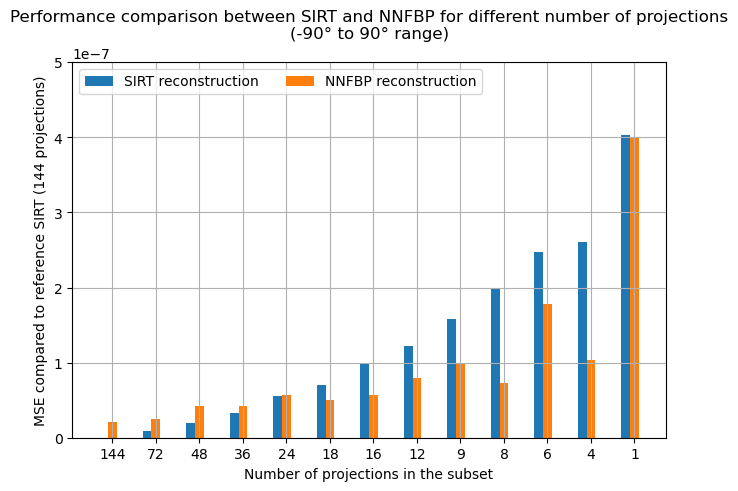

In [ ]:
# MSE SIRT against MSE NNFBP

mse_lists = {
    'SIRT reconstruction': mse_sirt,
    'NNFBP reconstruction': mse_nnfbp,
#    'MSE MSDNET': mse_msdnet,
}

x = np.arange(len(mse_sirt))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in mse_lists.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("Number of projections in the subset")
ax.set_ylabel('MSE compared to reference SIRT (144 projections)')
ax.set_title('Performance comparison between SIRT and NNFBP for different number of projections\n(-90° to 90° range)')
ax.set_xticks(x + width, subsets)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 5e-7)
ax.grid()
plt.show()

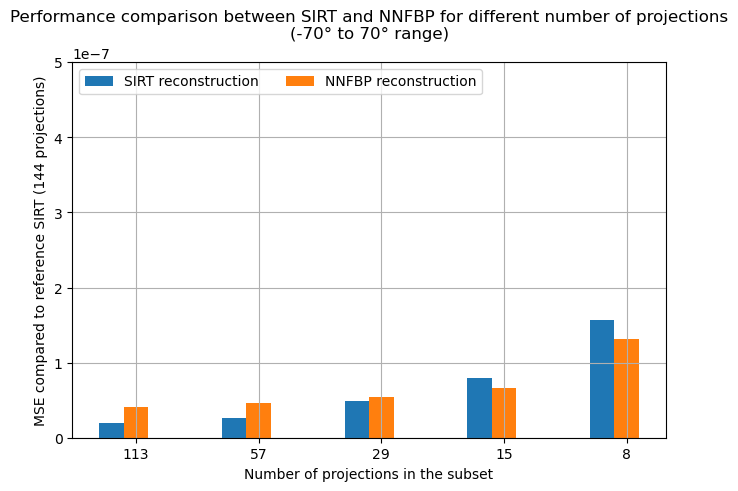

In [ ]:
# MSE SIRT against MSE NNFBP

mse_lists = {
    'SIRT reconstruction': mse_sirt_tem,
    'NNFBP reconstruction': mse_nnfbp_tem,
#    'MSE MSDNET': mse_msdnet,
}

x = np.arange(len(mse_sirt_tem))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in mse_lists.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("Number of projections in the subset")
ax.set_ylabel('MSE compared to reference SIRT (144 projections)')
ax.set_title('Performance comparison between SIRT and NNFBP for different number of projections\n(-70° to 70° range)')
ax.set_xticks(x + width, [tem_subset for tem_subset in tem_subsets if tem_subset is not None])
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 5e-7)
ax.grid()
plt.show()

MSE computations:[████████████████████████████████████████████████████████████] 139/139 Est wait 00:0.05




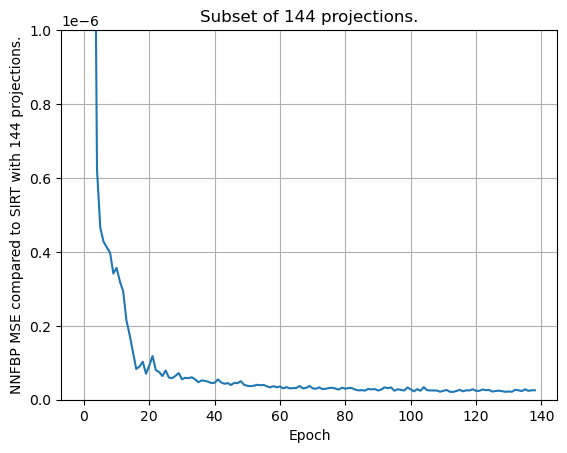

MSE computations:[████████████████████████████████████████████████████████████] 238/238 Est wait 00:0.02




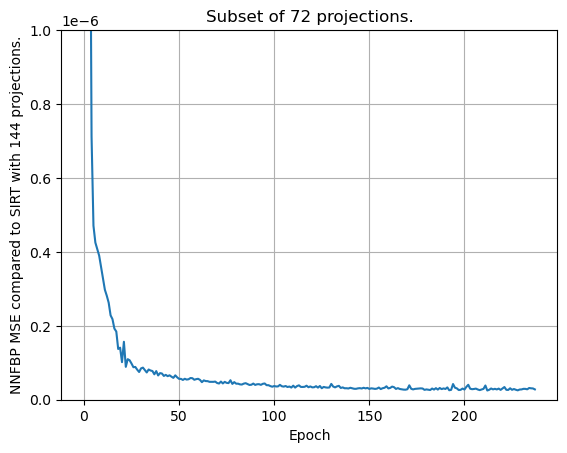

MSE computations:[████████████████████████████████████████████████████████████] 133/133 Est wait 00:0.09




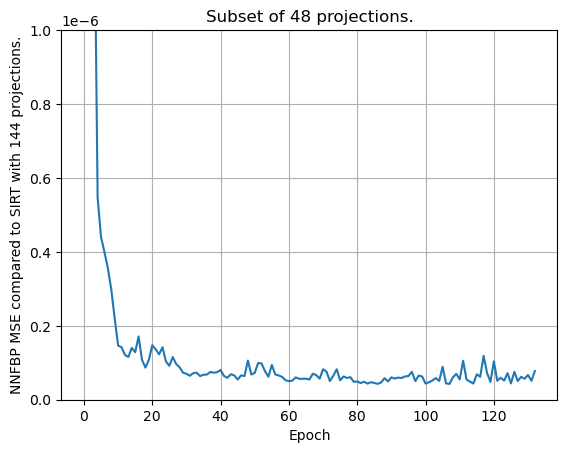

MSE computations:[████████████████████████████████████████████████████████████] 116/116 Est wait 00:0.09




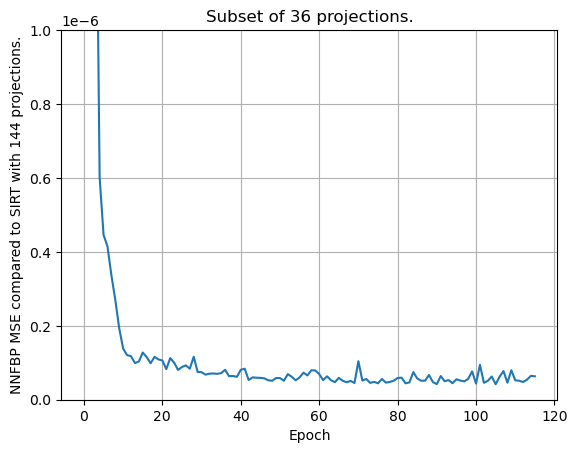

MSE computations:[████████████████████████████████████████████████████████████] 161/161 Est wait 00:0.06




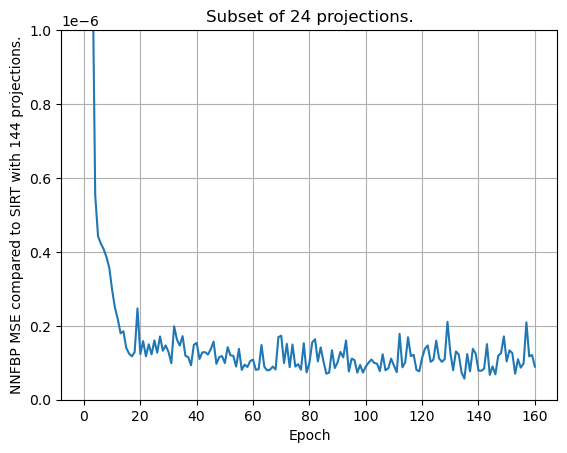

MSE computations:[████████████████████████████████████████████████████████████] 162/162 Est wait 00:0.00




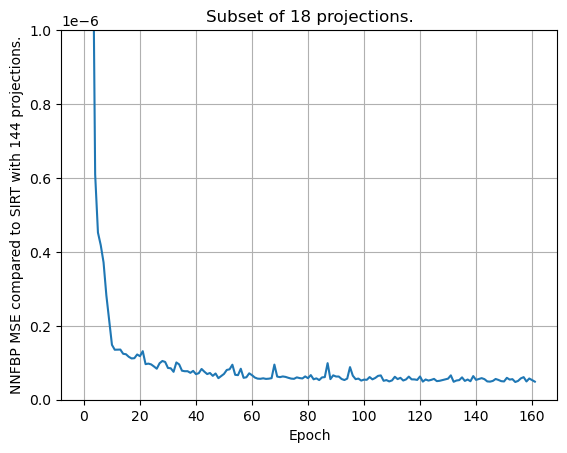

MSE computations:[████████████████████████████████████████████████████████████] 139/139 Est wait 00:0.08




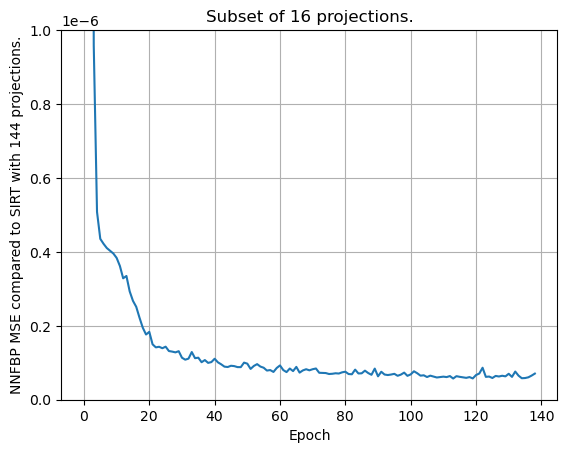

MSE computations:[████████████████████████████████████████████████████████████] 67/67 Est wait 00:0.06




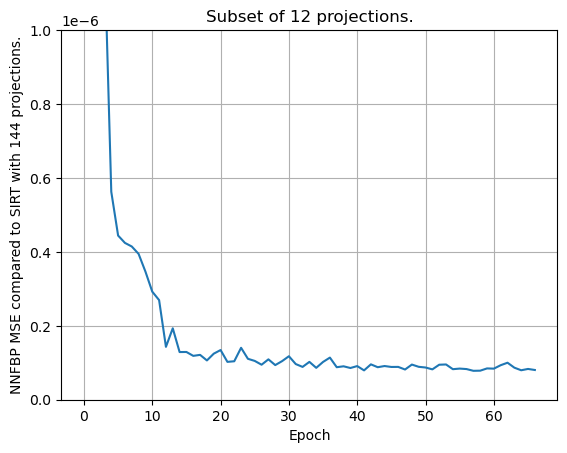

MSE computations:[████████████████████████████████████████████████████████████] 111/111 Est wait 00:0.05




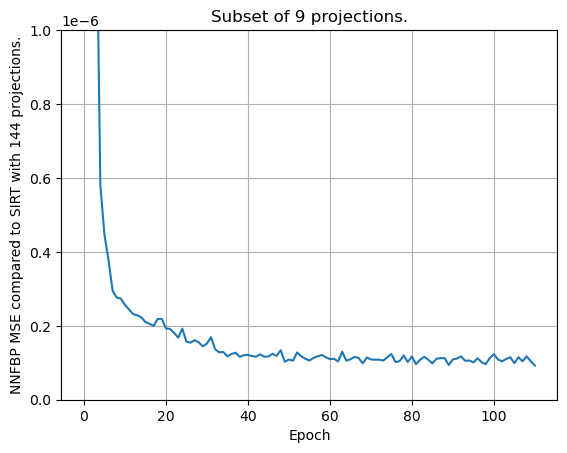

MSE computations:[████████████████████████████████████████████████████████████] 194/194 Est wait 00:0.04




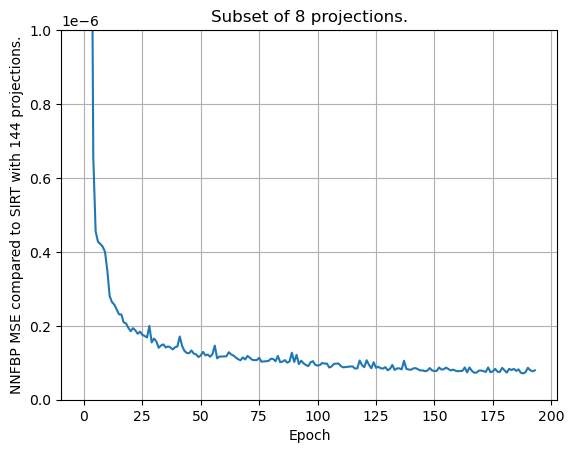

MSE computations:[████████████████████████████████████████████████████████████] 93/93 Est wait 00:0.05




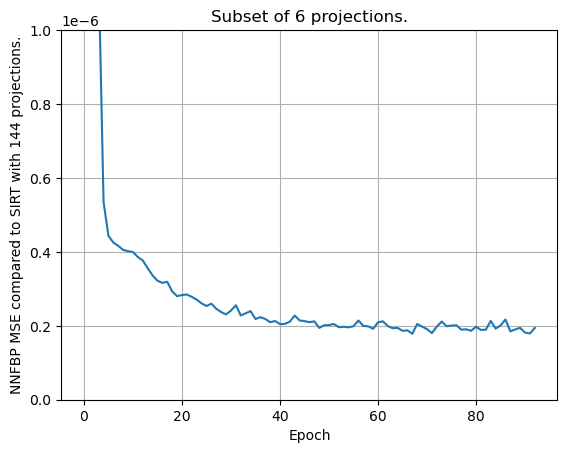

MSE computations:[████████████████████████████████████████████████████████████] 207/207 Est wait 00:0.06




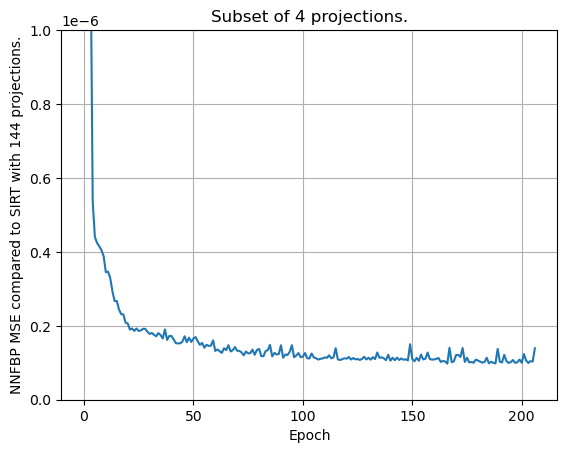

MSE computations:[████████████████████████████████████████████████████████████] 145/145 Est wait 00:0.05




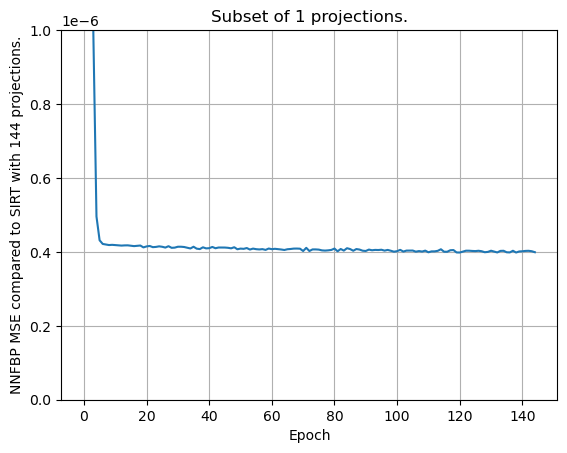

In [ ]:
for subset, network in zip(subsets, trained_networks_nnfbp):
    empty_cached_gpu_memory()
    # subsets

    uio67_stack_sub = uio67_stack.get_proj_subset(subset)

    mse_nn_evolution = get_MSE_evolution(network.id, uio67_stack_sub, sirt144_reconstruction, None)

    plt.plot(mse_nn_evolution)
    plt.grid()
    plt.title(f"Subset of {subset} projections.")
    plt.xlabel("Epoch")
    plt.ylabel("NNFBP MSE compared to SIRT with 144 projections.")
    plt.ylim((0,1e-6))
    plt.show()